Optimal parameters:
V0* = 0.010
sigma_F = 0.258
Maximum yield of B = 0.2395

Comparison:
Semibatch yield: 0.2395
CSTR yield: 0.0984
PFR yield: 0.2313
Improvement over best steady reactor: 0.0081


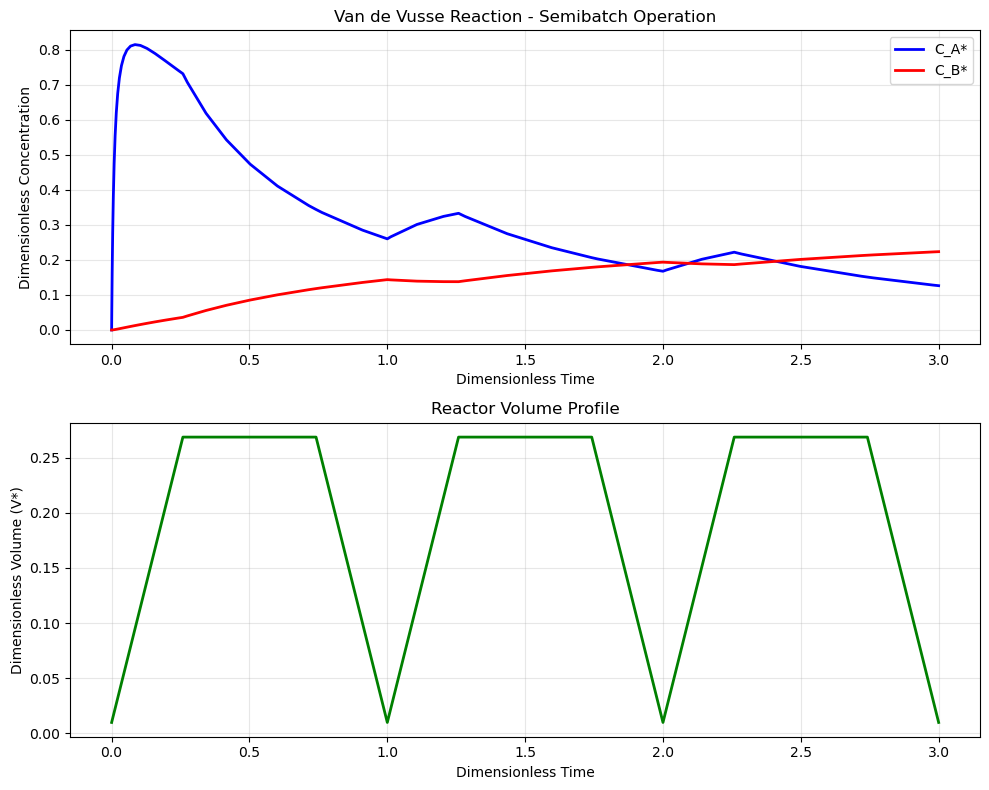

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

class VanDeVusseSemibatch:
    """
    Optimization of Van de Vusse reaction kinetics using semibatch reactor operation
    Based on: Ridlehoover & Seagrave, Ind. Eng. Chem. Fundam., Vol. 12, No. 4, 1973
    """
    
    def __init__(self, k1, k2, k3, CAf):
        """
        Initialize with kinetic parameters
        Reactions:
        A -> B (k1)
        B -> C (k2) 
        2A -> D (k3)
        """
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.CAf = CAf  # Feed concentration of A
        
        # Dimensionless parameters
        self.P2_P1 = k2 / k1
        self.P3_P1 = k3 * CAf / k1
        
    def semibatch_cycle(self, V0_star, sigma_F, Vm_Qt_ratio=0.35, cycles=5):
        """
        Simulate semibatch cycle operation
        
        Parameters:
        V0_star: dimensionless minimum volume (V0/Vm)
        sigma_F: fraction of cycle spent in filling
        Vm_Qt_ratio: Vm/Qt ratio (default 0.35/K1 as in paper)
        cycles: number of cycles to simulate
        """
        # Calculate cycle segment fractions
        sigma_E = sigma_F  # Equal filling and emptying rates
        sigma_B = 1 - sigma_F - sigma_E  # Batch fraction
        
        if sigma_B < 0:
            return None, None, None, None
        
        # Dimensionless parameters
        P1 = self.k1 * Vm_Qt_ratio
        P2 = self.k2 * Vm_Qt_ratio
        P3 = self.k3 * self.CAf * Vm_Qt_ratio
        
        # Time parameters
        theta_cycle = 1.0  # Total cycle time (dimensionless)
        theta_F = sigma_F * theta_cycle
        theta_B = sigma_B * theta_cycle
        theta_E = sigma_E * theta_cycle
        
        # Initial conditions (start of first filling)
        CA_star = 0.0  # Starting with empty reactor
        CB_star = 0.0
        V_star = V0_star
        
        time_history = [0]
        CA_history = [CA_star]
        CB_history = [CB_star]
        V_history = [V_star]
        
        current_time = 0
        
        for cycle in range(cycles):
            # Filling segment
            theta_span = [current_time, current_time + theta_F]
            sol = solve_ivp(
                self._filling_equations, theta_span, [CA_star, CB_star, V_star],
                args=(P1, P2, P3, V0_star), method='RK45', rtol=1e-6, atol=1e-8
            )
            
            # Update states
            CA_star, CB_star, V_star = sol.y[0, -1], sol.y[1, -1], sol.y[2, -1]
            
            # Store results
            time_history.extend(sol.t[1:])
            CA_history.extend(sol.y[0, 1:])
            CB_history.extend(sol.y[1, 1:])
            V_history.extend(sol.y[2, 1:])
            
            current_time += theta_F
            
            # Batch segment
            if theta_B > 0:
                theta_span = [current_time, current_time + theta_B]
                sol = solve_ivp(
                    self._batch_equations, theta_span, [CA_star, CB_star, V_star],
                    args=(P1, P2, P3), method='RK45', rtol=1e-6, atol=1e-8
                )
                
                CA_star, CB_star, V_star = sol.y[0, -1], sol.y[1, -1], sol.y[2, -1]
                
                time_history.extend(sol.t[1:])
                CA_history.extend(sol.y[0, 1:])
                CB_history.extend(sol.y[1, 1:])
                V_history.extend(sol.y[2, 1:])
                
                current_time += theta_B
            
            # Emptying segment
            theta_span = [current_time, current_time + theta_E]
            sol = solve_ivp(
                self._emptying_equations, theta_span, [CA_star, CB_star, V_star],
                args=(P1, P2, P3, V0_star), method='RK45', rtol=1e-6, atol=1e-8
            )
            
            CA_star, CB_star, V_star = sol.y[0, -1], sol.y[1, -1], sol.y[2, -1]
            
            time_history.extend(sol.t[1:])
            CA_history.extend(sol.y[0, 1:])
            CB_history.extend(sol.y[1, 1:])
            V_history.extend(sol.y[2, 1:])
            
            current_time += theta_E
        
        return (np.array(time_history), np.array(CA_history), 
                np.array(CB_history), np.array(V_history))
    
    def _filling_equations(self, theta, y, P1, P2, P3, V0_star):
        """
        Material balance equations during filling
        y = [CA*, CB*, V*]
        """
        CA_star, CB_star, V_star = y
        
        V_current = V0_star + theta
        
        # Component A
        dCA_dtheta = -P1 * CA_star - P3 * CA_star**2 - CA_star/V_current + 1/V_current
        
        # Component B  
        dCB_dtheta = P1 * CA_star - P2 * CB_star - CB_star/V_current
        
        # Volume (linear increase during filling)
        dV_dtheta = 1.0
        
        return [dCA_dtheta, dCB_dtheta, dV_dtheta]
    
    def _batch_equations(self, theta, y, P1, P2, P3):
        """
        Material balance equations during batch operation
        """
        CA_star, CB_star, V_star = y
        
        # Component A
        dCA_dtheta = -P1 * CA_star - P3 * CA_star**2
        
        # Component B
        dCB_dtheta = P1 * CA_star - P2 * CB_star
        
        # Volume (constant during batch)
        dV_dtheta = 0.0
        
        return [dCA_dtheta, dCB_dtheta, dV_dtheta]
    
    def _emptying_equations(self, theta, y, P1, P2, P3, V0_star):
        """
        Material balance equations during emptying
        """
        CA_star, CB_star, V_star = y
        
        # Component A (same as batch during emptying)
        dCA_dtheta = -P1 * CA_star - P3 * CA_star**2
        
        # Component B (same as batch during emptying)
        dCB_dtheta = P1 * CA_star - P2 * CB_star
        
        # Volume (linear decrease during emptying)
        dV_dtheta = -1.0
        
        return [dCA_dtheta, dCB_dtheta, dV_dtheta]
    
    def calculate_yield_B(self, V0_star, sigma_F, Vm_Qt_ratio=0.35, cycles=10):
        """
        Calculate time-average yield of B during emptying phase
        """
        time, CA, CB, V = self.semibatch_cycle(V0_star, sigma_F, Vm_Qt_ratio, cycles)
        
        if time is None:
            return -np.inf  # Invalid parameters
        
        # Find emptying phases (volume decreasing)
        emptying_mask = np.diff(V) < 0
        emptying_indices = np.where(emptying_mask)[0]
        
        if len(emptying_indices) == 0:
            return 0.0
        
        # Average CB during emptying (last few cycles for steady cycle)
        steady_cycle_start = max(0, len(CB) - int(2 * len(CB)/cycles))
        emptying_CB = CB[emptying_indices]
        emptying_CB_steady = emptying_CB[emptying_CB >= steady_cycle_start]
        
        if len(emptying_CB_steady) == 0:
            return np.mean(emptying_CB)
        
        return np.mean(emptying_CB_steady)
    
    def optimize_semibatch(self, Vm_Qt_ratio=0.35):
        """
        Optimize semibatch operation to maximize yield of B
        """
        def objective(x):
            V0_star, sigma_F = x
            # Constrain parameters
            if V0_star <= 0 or V0_star >= 1 or sigma_F <= 0 or sigma_F >= 0.5:
                return -np.inf
            return -self.calculate_yield_B(V0_star, sigma_F, Vm_Qt_ratio)
        
        # Initial guess
        x0 = [0.5, 0.1]  # V0_star, sigma_F
        
        # Bounds
        bounds = [(0.01, 0.99), (0.01, 0.49)]
        
        # Optimization
        result = minimize(objective, x0, bounds=bounds, method='L-BFGS-B')
        
        if result.success:
            V0_opt, sigma_F_opt = result.x
            max_yield = -result.fun
            return V0_opt, sigma_F_opt, max_yield
        else:
            print("Optimization failed:", result.message)
            return None, None, None
    
    def compare_reactors(self, V0_star, sigma_F, Vm_Qt_ratio=0.35):
        """
        Compare semibatch performance with CSTR and PFR
        """
        # Semibatch yield
        Y_semibatch = self.calculate_yield_B(V0_star, sigma_F, Vm_Qt_ratio)
        
        # CSTR yield
        tau_ref = Vm_Qt_ratio / sigma_F  # Reference residence time
        CA_star_CSTR = 1 / (1 + self.k1 * tau_ref + self.k3 * self.CAf * tau_ref)
        CB_star_CSTR = (self.k1 * tau_ref * CA_star_CSTR) / (1 + self.k2 * tau_ref)
        Y_CSTR = CB_star_CSTR
        
        # PFR yield (approximate)
        def pfr_equations(t, y):
            CA, CB = y
            dCA_dt = -self.k1 * CA - self.k3 * CA**2
            dCB_dt = self.k1 * CA - self.k2 * CB
            return [dCA_dt, dCB_dt]
        
        sol_pfr = solve_ivp(pfr_equations, [0, tau_ref], [self.CAf, 0], 
                           method='RK45', rtol=1e-6)
        Y_PFR = sol_pfr.y[1, -1] / self.CAf
        
        return Y_semibatch, Y_CSTR, Y_PFR

def create_optimization_plot():
    """
    Create optimization plot similar to Figure 3 in the paper
    """
    # Example parameters from the paper
    k1 = 1.0
    k2 = 0.12 * k1  # P2/P1 = 0.12
    CAf = 1.0
    k3 = 7.0 * k1 / CAf  # P3/P1 = 7.0
    
    reactor = VanDeVusseSemibatch(k1, k2, k3, CAf)
    
    # Optimize for these parameters
    V0_opt, sigma_F_opt, Y_opt = reactor.optimize_semibatch()
    
    print(f"Optimal parameters:")
    print(f"V0* = {V0_opt:.3f}")
    print(f"sigma_F = {sigma_F_opt:.3f}")
    print(f"Maximum yield of B = {Y_opt:.4f}")
    
    # Compare with other reactors
    Y_semi, Y_CSTR, Y_PFR = reactor.compare_reactors(V0_opt, sigma_F_opt)
    print(f"\nComparison:")
    print(f"Semibatch yield: {Y_semi:.4f}")
    print(f"CSTR yield: {Y_CSTR:.4f}")
    print(f"PFR yield: {Y_PFR:.4f}")
    print(f"Improvement over best steady reactor: {Y_semi - max(Y_CSTR, Y_PFR):.4f}")
    
    # Simulate and plot cycle
    time, CA, CB, V = reactor.semibatch_cycle(V0_opt, sigma_F_opt, cycles=3)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Concentration profiles
    ax1.plot(time, CA, 'b-', label='C_A*', linewidth=2)
    ax1.plot(time, CB, 'r-', label='C_B*', linewidth=2)
    ax1.set_ylabel('Dimensionless Concentration')
    ax1.set_xlabel('Dimensionless Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Van de Vusse Reaction - Semibatch Operation')
    
    # Volume profile
    ax2.plot(time, V, 'g-', linewidth=2)
    ax2.set_ylabel('Dimensionless Volume (V*)')
    ax2.set_xlabel('Dimensionless Time')
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Reactor Volume Profile')
    
    plt.tight_layout()
    plt.show()
    
    return reactor, V0_opt, sigma_F_opt, Y_opt

# Run the optimization example
if __name__ == "__main__":
    reactor, V0_opt, sigma_F_opt, Y_opt = create_optimization_plot()